# **Import Google Drive**


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Setting**


In [11]:
from sklearn.isotonic import isotonic_regression
import cvxpy as cp
import numpy as np
import csv, os
from scipy import stats
from sklearn import metrics
import itertools
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statistics
from scipy.stats import levene
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Reinstall LaTeX dependencies to ensure they are properly set up
!apt-get update
!apt-get install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

# Set the text properties to use LaTeX fonts
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'  # Use serif fonts to match LaTeX's default
plt.rcParams['font.size'] = 30
plt.rcParams['figure.figsize'] = (13,8)  # width, height in inches
plt.rcParams['figure.dpi'] = 300  # dots per inch


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

# **Function: Partition all submissions according to "Greedy" and "Multi-owner" methods**


In [12]:
def validate(partition, graph, n):
	# check that
	# 1. each paper is in exactly one partition
	# 2. the number of papers in all partition is equal to the number of papers
	# 3. each partition has at least two authors owns all papers in the partition

	papers = set()
	full_author_parts = []
	for part in partition[:-1]:
		assert( len(part.intersection(papers)) == 0 )
		papers |= part
		# find all authors that can rank all papers in this part
		cnt = 0
		author_part = set()
		for author, val in graph.items():
			if len(val.intersection(part)) == len(part):
				cnt += 1
				author_part.add(author)

		# assert( cnt >= 2 )
		full_author_parts.append(author_part)

	# add the last partition
	full_author_parts.append(set())
	papers |= partition[-1]
	assert(len(papers) == n)

	return full_author_parts


def greedy(graph, m, n, randomize=False, level=1):
	partition = []
	author_parts = []
	allocated_papers = set()

	if level == 1:
		parts = [ graph[i].copy() for i in range(m) ]
		index2pair = [ set([i]) for i in range(m) ]
	elif level == 2:
		parts = [ graph[i].intersection(graph[j])  for i in range(m) for j in range(i+1, m) ]
		index2pair = [ set([i,j]) for i in range(m) for j in range(i+1, m) ]

	max_idx = 0
	max_val = 0
	active_indices = set( [i for i in range(len(parts)) if len(parts[i]) > 1] )
	# for i in range(0, len(parts)):
	for i in active_indices:
		if len(parts[i]) > max_val:
			max_idx = i
			max_val = len(parts[i])

	while len(allocated_papers) < n and len(parts[max_idx]) > 1:
		max_part = parts[max_idx].copy()
		partition.append( max_part )
		author_parts.append( index2pair[max_idx] )
		allocated_papers |= max_part

		max_idx = 0
		max_val = 0
		# for i in range(0, len(parts)):
		to_remove = set()
		for i in active_indices:
			parts[i].difference_update(max_part)
			if len(parts[i]) < 2:
				to_remove.add(i)
				continue
			if len(parts[i]) > max_val:
				max_idx = i
				max_val = len(parts[i])
		max_part = parts[max_idx].copy()
		active_indices.difference_update(to_remove)

	# add all remaining papers to the last partition
	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


def arbitrary(graph, m, n, randomize=False):
	partition = []
	author_parts = []
	allocated_papers = set()

	parts = [ graph[i].copy() for i in range(m) ]
	index2pair = [ set([i]) for i in range(m) ]

	idx = 0
	while len(parts[idx]) < 2 and idx < len(parts)-1: idx += 1

	while len(allocated_papers) < n and idx != -1:
		part = parts[idx].copy()

		partition.append( part )
		author_parts.append( index2pair[idx] )
		allocated_papers |= part

		idx = -1
		val = None
		for i in range(0, len(parts)):
			parts[i].difference_update(part)
			if len(parts[i]) >= 2:
				idx = i
				val = len(parts[i])

	partition.append(set())
	author_parts.append(set())
	for i in range(n):
		if i not in allocated_papers:
			partition[-1].add(i)

	return partition, author_parts


# **Simple-averaging Isotonic Scores, Proxy**


## Load CSV file into a pandas DataFrame


In [13]:
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/ICML_2023_Result/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])

## Organize each block by {author: [submission, rank, score]}.


In [14]:
author_submission_rank_old = {}
authors = df['author_idx'].unique()
for author in authors:
    author_submission_rank_old[author] = []
    submissions = list(set(df[df['author_idx'] == author]['submission_idx'].tolist()))

    for i in range(len(submissions)):
        rank = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['rank'].tolist()[0]
        ratings = df[(df['submission_idx'] == submissions[i]) & (df['author_idx'] == author)]['score'].tolist()[0]
        author_submission_rank_old[author].append((submissions[i], rank, ratings))

## Sort submissions by rank; in case of ties, sort by score.


In [15]:
def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
        author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old

author_submission_rank_old = sort_submissions(author_submission_rank_old)

## Compute isotonic scores for each author.


In [16]:
author_submission_rank_new = {}
for author in author_submission_rank_old:
    ir_rank = []
    for i in range(len(author_submission_rank_old[author])):
        r1 = author_submission_rank_old[author][i][2]
        ir_rank.append(r1)
    ir_rank = np.array(ir_rank)
    ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

    author_submission_rank_new[author] = []
    for i in range(len(author_submission_rank_old[author])):
        author_submission_rank_new[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))


## For multi-author submissions, average the scores to get the isotonic score.


In [17]:
final_submission_list = df['submission_idx'].unique()

submission_new_rating = {}
for submission in final_submission_list:
    submission_new_rating[submission] = []

for author in author_submission_rank_new:
    for i in range(len(author_submission_rank_new[author])):
      if author_submission_rank_new[author][i][0] in final_submission_list:
        submission_new_rating[author_submission_rank_new[author][i][0]].append(author_submission_rank_new[author][i][2])

for submission in final_submission_list:
    submission_new_rating[submission] = [float(rating) for rating in submission_new_rating[submission]]
    avg_rating = sum(submission_new_rating[submission])/len(submission_new_rating[submission])
    submission_new_rating[submission] = avg_rating

## Compute MSE values for all submissions and Plot.


In [18]:
# Isotonic score
adhoc_iso_rating = []
for submission in final_submission_list:
  adhoc_iso_rating.append(submission_new_rating[submission])



# Proxy
submission_true_rating = {}
for submission in final_submission_list:
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for submission in final_submission_list:
    True_score_multi_iso.append(submission_true_rating[submission])



# Score
old_rating = {}
for submission in final_submission_list:
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for submission in final_submission_list:
    old_score_multi_iso.append(old_rating[submission])



# Compute MSE
print('Simple-averaging Isotonic Mechanism', mean_squared_error(adhoc_iso_rating, True_score_multi_iso))
print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso))



# Create two lists to record: (y - R)^2 and (\hat{R} - R)^2 values.
adhoc_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  adhoc_diff.append( (adhoc_iso_rating[i] - True_score_multi_iso[i])**2 )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )



#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_rel(old_diff, adhoc_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for greedy:", t_statistic)
print("Before Rebuttal with proxy p-value for greedy:", p_value)




Simple-averaging Isotonic Mechanism 1.9656811444437243
Review Rating 2.5687166227492315
Before Rebuttal with proxy t-test for greedy: 14.077424493107163
Before Rebuttal with proxy p-value for greedy: 1.0876416396012888e-43


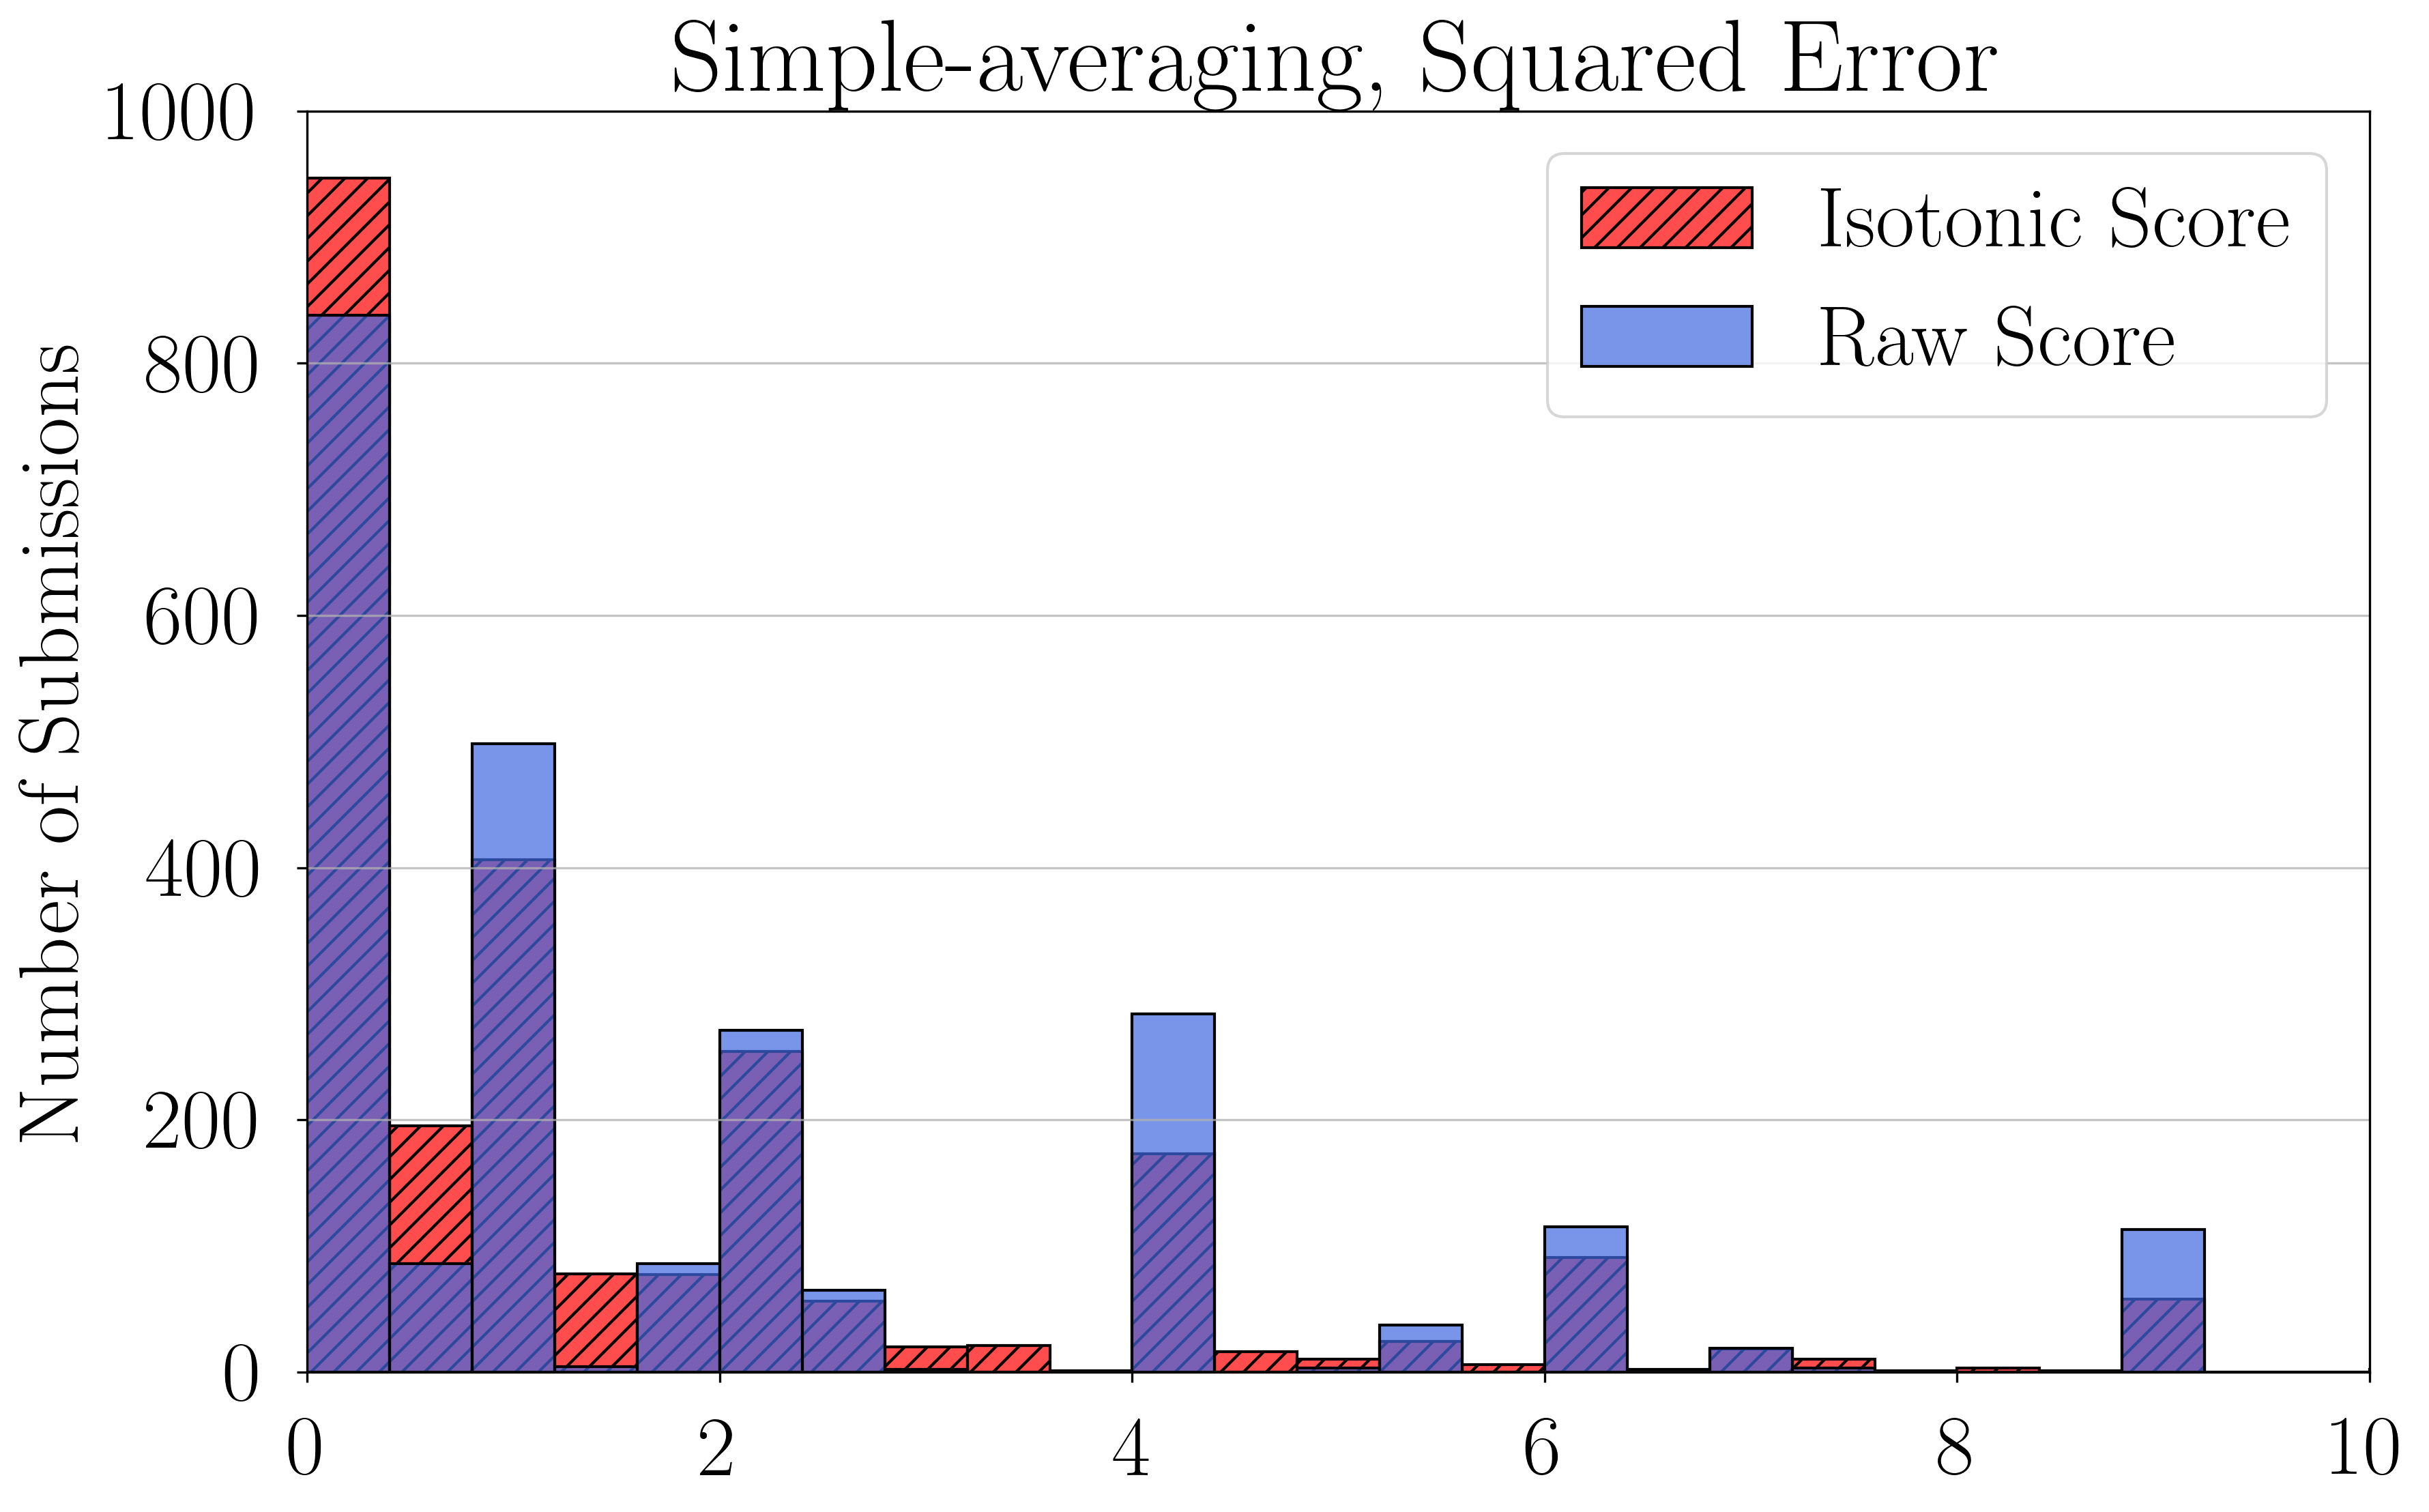

In [19]:

# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=adhoc_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='Isotonic Score    ', common_norm=False, alpha=0.7, hatch='///', line_kws={'lw': 2.5} )
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=False, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Proxy MSE')
plt.ylabel('Number of Submissions')
plt.title('Simple-averaging, Squared Error')
plt.xlim(0, 10)
plt.yticks(range(0, 1001, 200))


plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)


plt.legend()
plt.savefig('/content/drive/MyDrive/Research/ICML_2023_Result/Figures/adhoc_iso_proxy_histo_L2.pdf', bbox_inches='tight')

# Show the plot
plt.show()



## Compute L_1 values for all submissions and Plot.


In [20]:
# Isotonic score
adhoc_iso_rating = []
for submission in final_submission_list:
  adhoc_iso_rating.append(submission_new_rating[submission])



# Proxy
submission_true_rating = {}
for submission in final_submission_list:
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for submission in final_submission_list:
    True_score_multi_iso.append(submission_true_rating[submission])



# Score
old_rating = {}
for submission in final_submission_list:
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for submission in final_submission_list:
    old_score_multi_iso.append(old_rating[submission])



# Create two lists to record: (y - R)^2 and (\hat{R} - R)^2 values.
adhoc_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  adhoc_diff.append( abs(adhoc_iso_rating[i] - True_score_multi_iso[i]) )
  old_diff.append( abs(old_score_multi_iso[i] - True_score_multi_iso[i]) )



# Compute MSE
print('Simple-averaging Isotonic Mechanism', np.mean(adhoc_diff) )
print('Review Rating', np.mean(old_diff) )



#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_rel(old_diff, adhoc_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for greedy:", t_statistic)
print("Before Rebuttal with proxy p-value for greedy:", p_value)




Simple-averaging Isotonic Mechanism 1.095422800026061
Review Rating 1.255566534914361
Before Rebuttal with proxy t-test for greedy: 13.36514197985571
Before Rebuttal with proxy p-value for greedy: 1.0174768401276418e-39


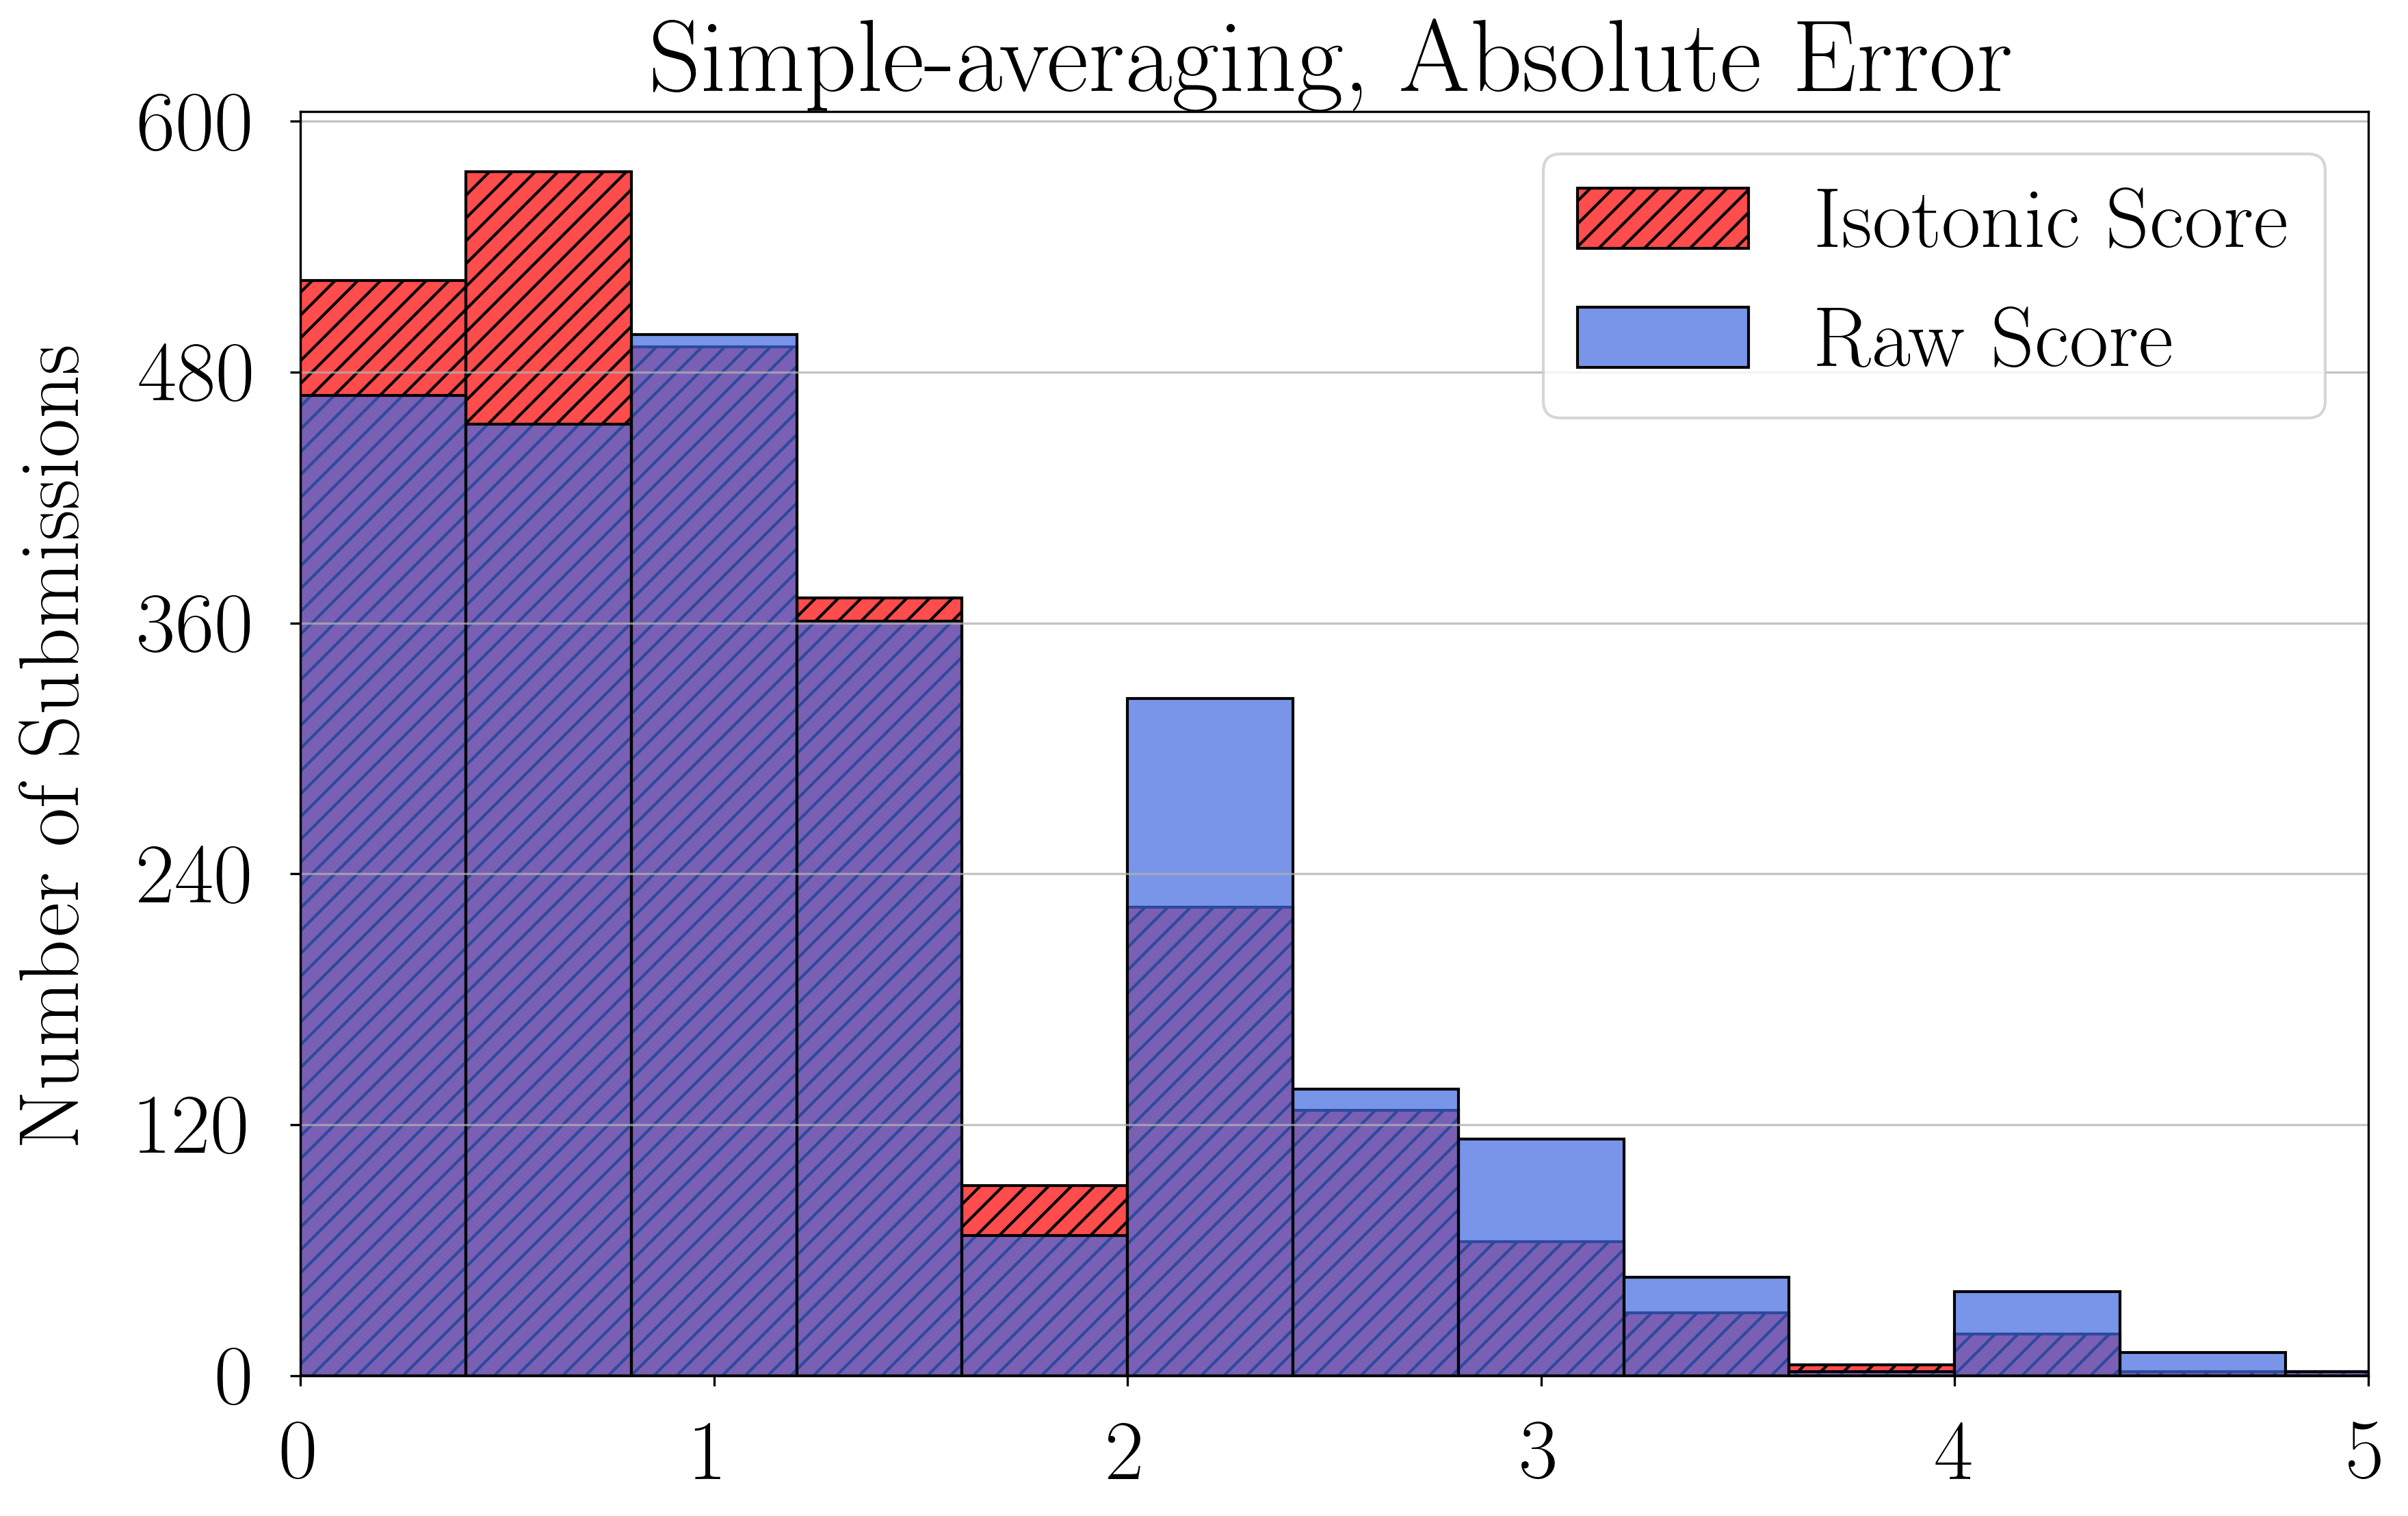

In [21]:

# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=adhoc_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='Isotonic Score    ', common_norm=False, alpha=0.7, hatch='///', line_kws={'lw': 2.5}, kde_kws={"bw_adjust": 1.5} )
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=False, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5}, kde_kws={"bw_adjust": 1.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Proxy MAE')
plt.ylabel('Number of Submissions', labelpad=15)
plt.title('Simple-averaging, Absolute Error')
plt.xlim(0, 5)
plt.yticks(range(0, 601, 120))



plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)


plt.legend()
plt.savefig('/content/drive/MyDrive/Research/ICML_2023_Result/Figures/adhoc_iso_proxy_histo_L1.pdf', bbox_inches='tight')
# Show the plot
plt.show()

# **Greedy/Multi-owner Isotonic Scores, Proxy**

## Load CSV file into a pandas DataFrame


In [22]:
# Load CSV file into a pandas DataFrame
df = pd.read_csv(r'/content/drive/MyDrive/Research/ICML_2023_Result/proxy_score.csv')
df = df.drop_duplicates(['submission_idx', 'author_idx'])


# Extract the unique authors from the DataFrame
authors = df['author_idx'].unique()
submissions = df['submission_idx'].unique()

author_submission = {}
for author in authors:
    submissionss = list( set(df[df['author_idx'] == author]['submission_idx'].tolist()) )
    author_submission[author] = submissionss

m_2 = len(author_submission)
n_2 = len(submissions)

## Organize all the authors and submissions as the following 'graph': authors = [..., {..., paper_idx : ranking, ...}, ...]


In [23]:
authors = []
for author in author_submission:
    submission_ranking = {}
    for i in range(len(author_submission[author])):
        submission_ranking[author_submission[author][i]] = df[(df['submission_idx'] == author_submission[author][i]) & (df['author_idx'] == author)]['rank'].tolist()
        submission_ranking[author_submission[author][i]] = submission_ranking[author_submission[author][i]][0]
    authors.append(submission_ranking)

graph = {}
for i, author in enumerate(authors):
    graph[i] = set( int(k) for k in author.keys())



## Multi-owner Isotonic


In [24]:
# Partition all the graph according to Multi-owner algorithm
partition, author_parts = arbitrary(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)

calibrated_scores = np.zeros(n_2)
for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue
  paper_part = list(part)



  # Organize each block by {author: [submission, rank, score]}.
  author_submission_rank_old = {}
  for author in author_part:
    author_submission_rank_old[author] = []
    for i in range(len(paper_part)):
        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()[0]
        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()[0]
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))



  # Sort submissions by rank; in case of ties, sort by score.
  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old
  author_submission_rank_old = sort_submissions(author_submission_rank_old)



  # Compute isotonic scores for each author in the block.
  author_submission_rank_multi_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

      author_submission_rank_multi_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_multi_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))



  # For multi-author submissions in a block, average the scores to get the isotonic score.
  submission_multi_iso_rating = {}
  for submission in paper_part:
      submission_multi_iso_rating[submission] = []

  for author in author_submission_rank_multi_iso:
      for i in range(len(author_submission_rank_multi_iso[author])):
          submission_multi_iso_rating[author_submission_rank_multi_iso[author][i][0]].append(author_submission_rank_multi_iso[author][i][2])

  for submission in submission_multi_iso_rating:
      submission_multi_iso_rating[submission] = [float(rating) for rating in submission_multi_iso_rating[submission]]
      avg_rating = sum(submission_multi_iso_rating[submission])/len(submission_multi_iso_rating[submission])
      submission_multi_iso_rating[submission] = avg_rating

  for i in paper_part:
    calibrated_scores[i] = submission_multi_iso_rating[i]



# Multi-owner Isotonic Score
multi_iso_rating = []
for i in range(n_2):
  multi_iso_rating.append(calibrated_scores[i])

## Greedy Isotonic


In [25]:
# Partition all the graph according to greedy algorithm
partition, author_parts = greedy(graph, m_2, n_2)
author_parts = validate(partition, graph, n_2)

calibrated_scores = np.zeros(n_2)
for part, author_part in zip(partition, author_parts):
  if len(author_part) == 0:
    for i in part: calibrated_scores[i] = df[df['submission_idx'] == i]['score'].tolist()[0]
    continue
  paper_part = list(part)



  # Organize each block by {author: [submission, rank, score]}.
  author_submission_rank_old = {}
  for author in author_part:
    author_submission_rank_old[author] = []
    for i in range(len(paper_part)):
        rank = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['rank'].tolist()[0]
        ratings = df[(df['submission_idx'] == paper_part[i]) & (df['author_idx'] == author)]['score'].tolist()[0]
        author_submission_rank_old[author].append((paper_part[i], rank, ratings))



  # Sort submissions by rank; in case of ties, sort by score.
  def sort_submissions(author_submission_rank_old):
    for author in author_submission_rank_old:
      author_submission_rank_old[author].sort(key=lambda x: (x[1], -x[2]), reverse=False)
    return author_submission_rank_old
  author_submission_rank_old = sort_submissions(author_submission_rank_old)



  # Compute isotonic scores for each author in the block.
  author_submission_rank_greedy_iso = {}
  for author in author_submission_rank_old:
      ir_rank = []
      for i in range(len(author_submission_rank_old[author])):
          r1 = author_submission_rank_old[author][i][2]
          ir_rank.append(r1)
      ir_rank = np.array(ir_rank)
      ir_rank_pred =  isotonic_regression(ir_rank, sample_weight = None, y_min=0.0, y_max=10.0, increasing=False)

      author_submission_rank_greedy_iso[author] = []
      for i in range(len(author_submission_rank_old[author])):
          author_submission_rank_greedy_iso[author].append((author_submission_rank_old[author][i][0], author_submission_rank_old[author][i][1], ir_rank_pred[i]))



  # For multi-author submissions in a block, average the scores to get the isotonic score.
  submission_greedy_iso_rating = {}
  for submission in paper_part:
      submission_greedy_iso_rating[submission] = []

  for author in author_submission_rank_greedy_iso:
      for i in range(len(author_submission_rank_greedy_iso[author])):
          submission_greedy_iso_rating[author_submission_rank_greedy_iso[author][i][0]].append(author_submission_rank_greedy_iso[author][i][2])

  for submission in submission_greedy_iso_rating:
      submission_greedy_iso_rating[submission] = [float(rating) for rating in submission_greedy_iso_rating[submission]]
      avg_rating = sum(submission_greedy_iso_rating[submission])/len(submission_greedy_iso_rating[submission])
      submission_greedy_iso_rating[submission] = avg_rating

  for i in paper_part:
    calibrated_scores[i] = submission_greedy_iso_rating[i]



# Greedy Isotonic Score
greedy_iso_rating = []
for i in range(n_2):
  greedy_iso_rating.append(calibrated_scores[i])

## Compute MSE values for all submissions.

In [26]:
# proxy
submission_true_rating = {}
for submission in range(n_2):
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for i in range(n_2):
    True_score_multi_iso.append(submission_true_rating[i])



# score
old_rating = {}
for submission in range(n_2):
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for i in range(n_2):
    old_score_multi_iso.append(old_rating[i])



# print the MSE
print('Greedy Isotonic Mechanism', mean_squared_error(greedy_iso_rating, True_score_multi_iso))
print('Multiowner Isotonic Mechanism', mean_squared_error(multi_iso_rating, True_score_multi_iso))
#print('Singal Isotonic Mechanism:', mean_squared_error(iso_rating, True_score))
print('Review Rating', mean_squared_error(old_score_multi_iso, True_score_multi_iso))



# Create two lists to record: (y - R)^2 and (\hat{R} - R)^2 values.
greedy_diff = []
multi_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  greedy_diff.append( (greedy_iso_rating[i] - True_score_multi_iso[i])**2 )
  multi_diff.append( (multi_iso_rating[i] - True_score_multi_iso[i])**2 )
  old_diff.append( (old_score_multi_iso[i] - True_score_multi_iso[i])**2 )



#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_rel(old_diff, greedy_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for greedy:", t_statistic)
print("Before Rebuttal with proxy p-value for greedy:", p_value)



#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_rel(old_diff, multi_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for multi-owner:", t_statistic)
print("Before Rebuttal with proxy p-value for multi-owner:", p_value)


Greedy Isotonic Mechanism 2.0216258401421445
Multiowner Isotonic Mechanism 2.070980801806889
Review Rating 2.5687166227492315
Before Rebuttal with proxy t-test for greedy: 12.583135081654703
Before Rebuttal with proxy p-value for greedy: 1.455040114632192e-35
Before Rebuttal with proxy t-test for multi-owner: 12.273773197644164
Before Rebuttal with proxy p-value for multi-owner: 5.579703229116071e-34


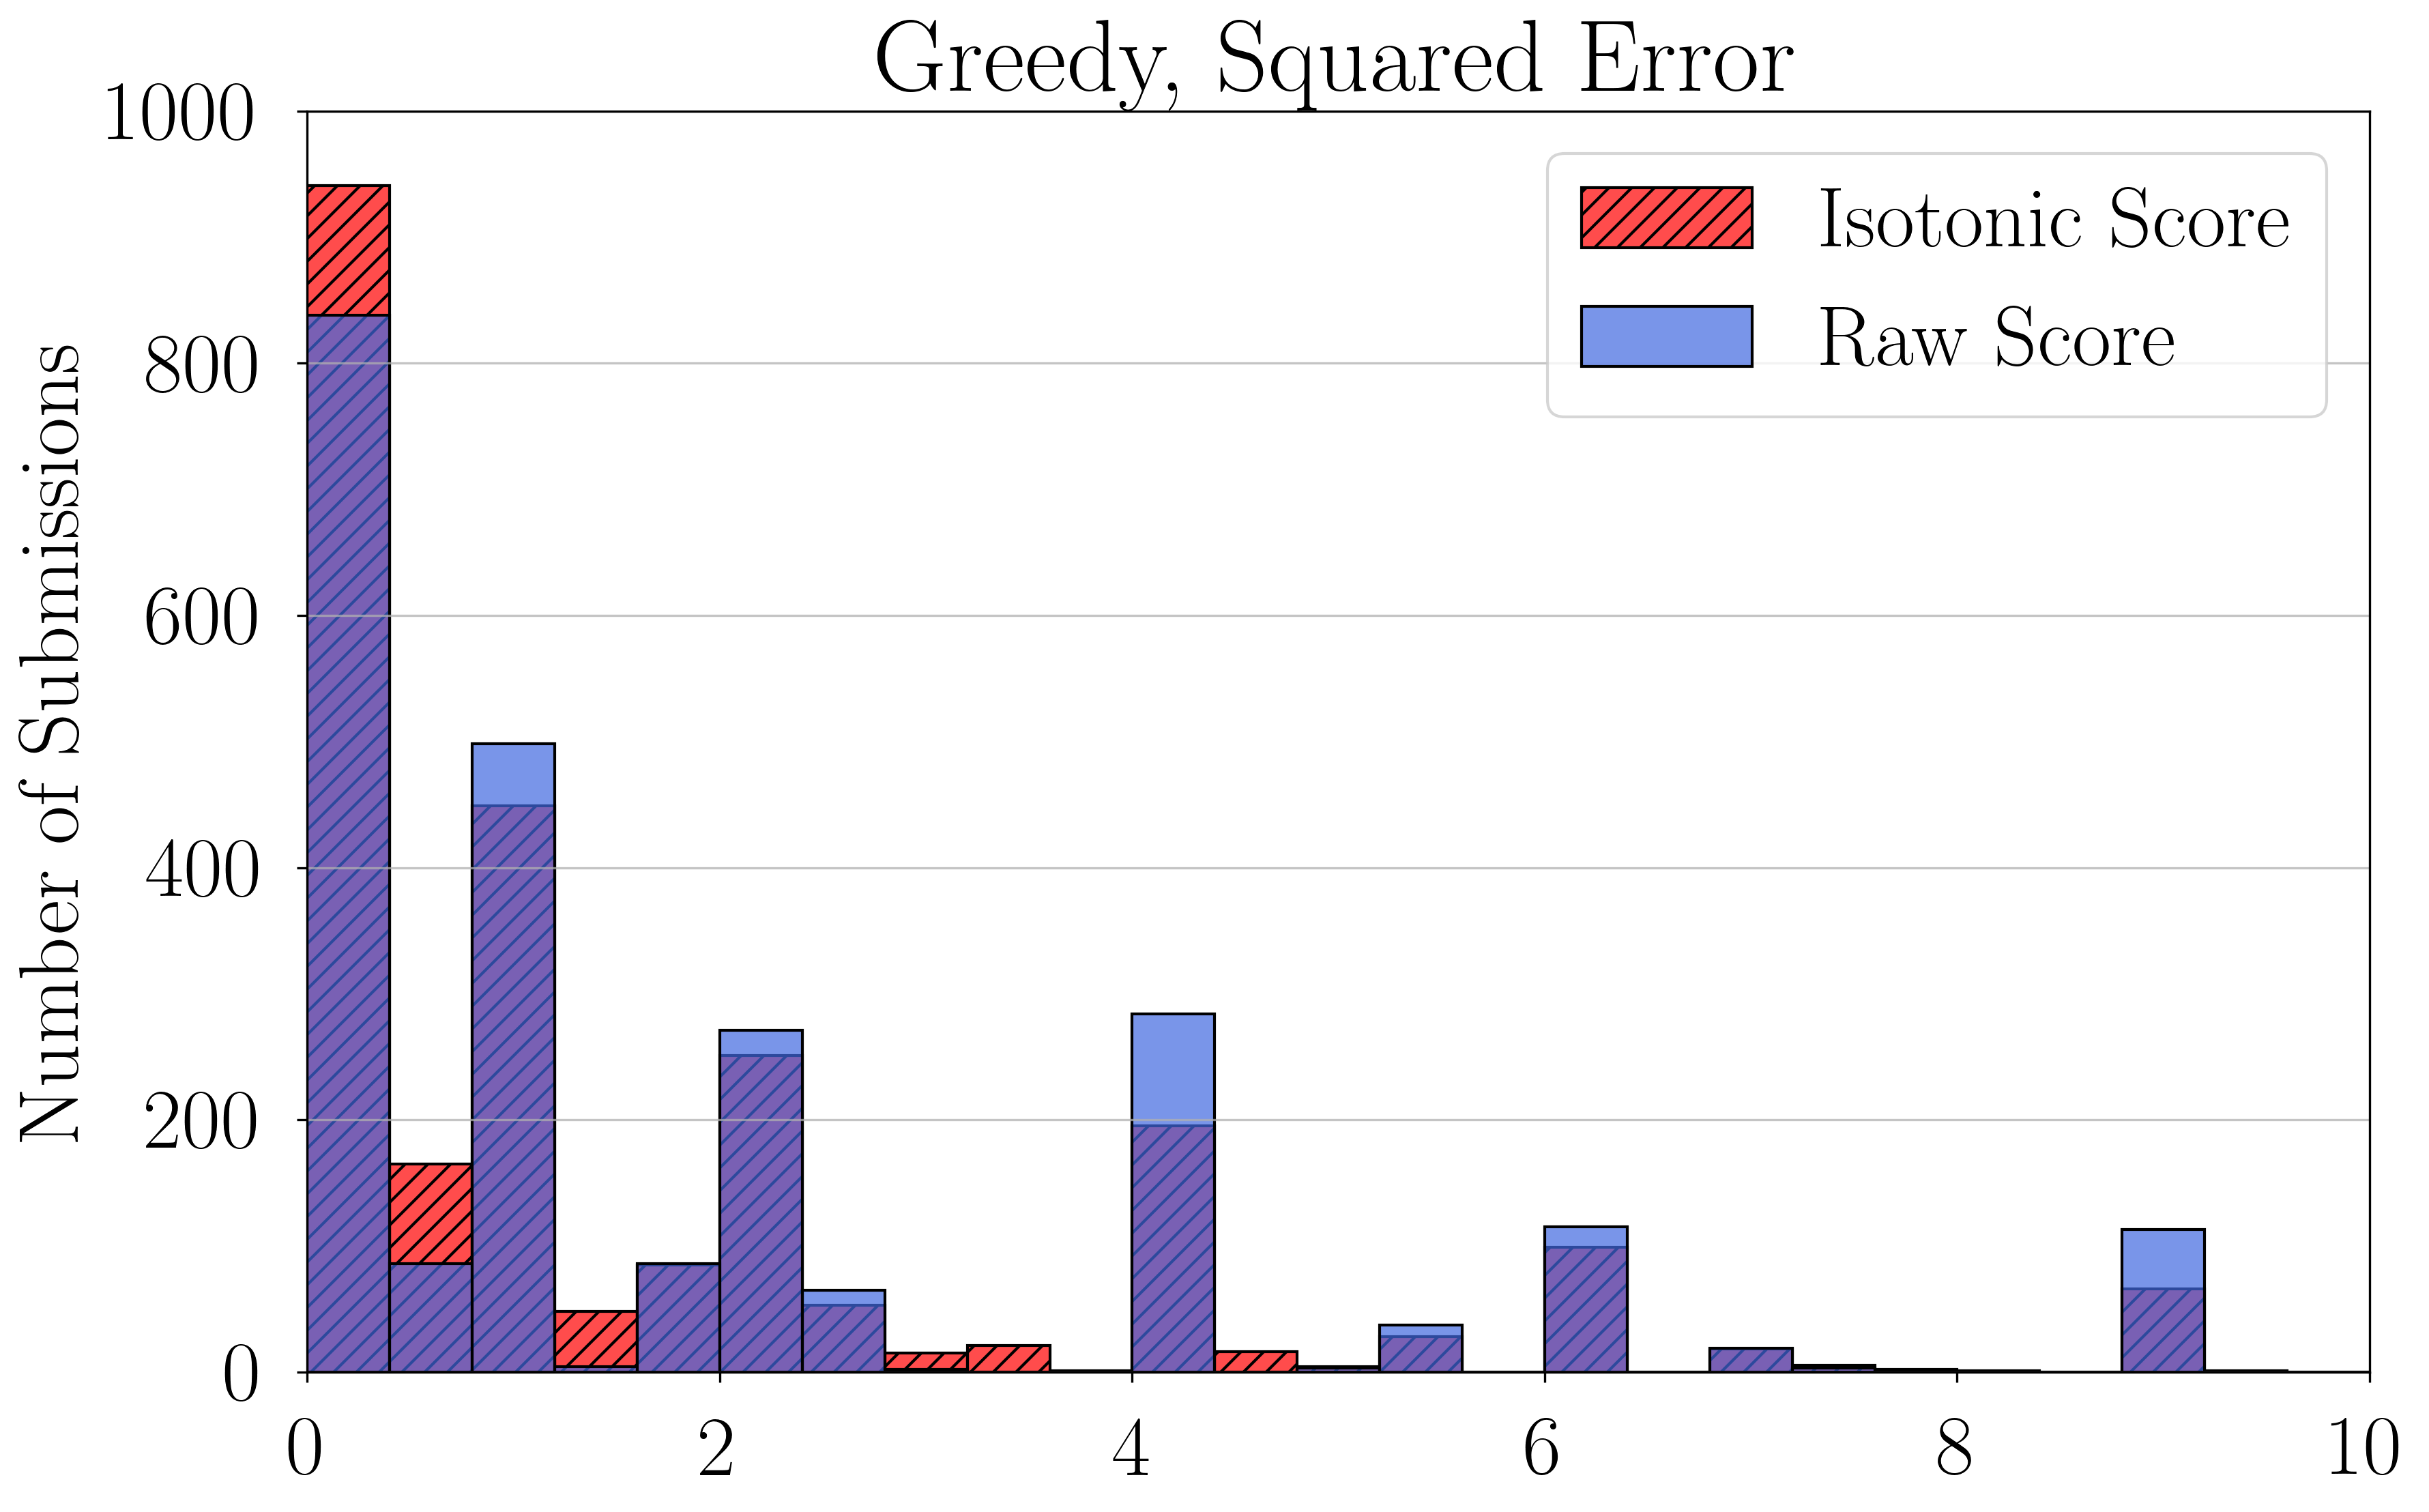

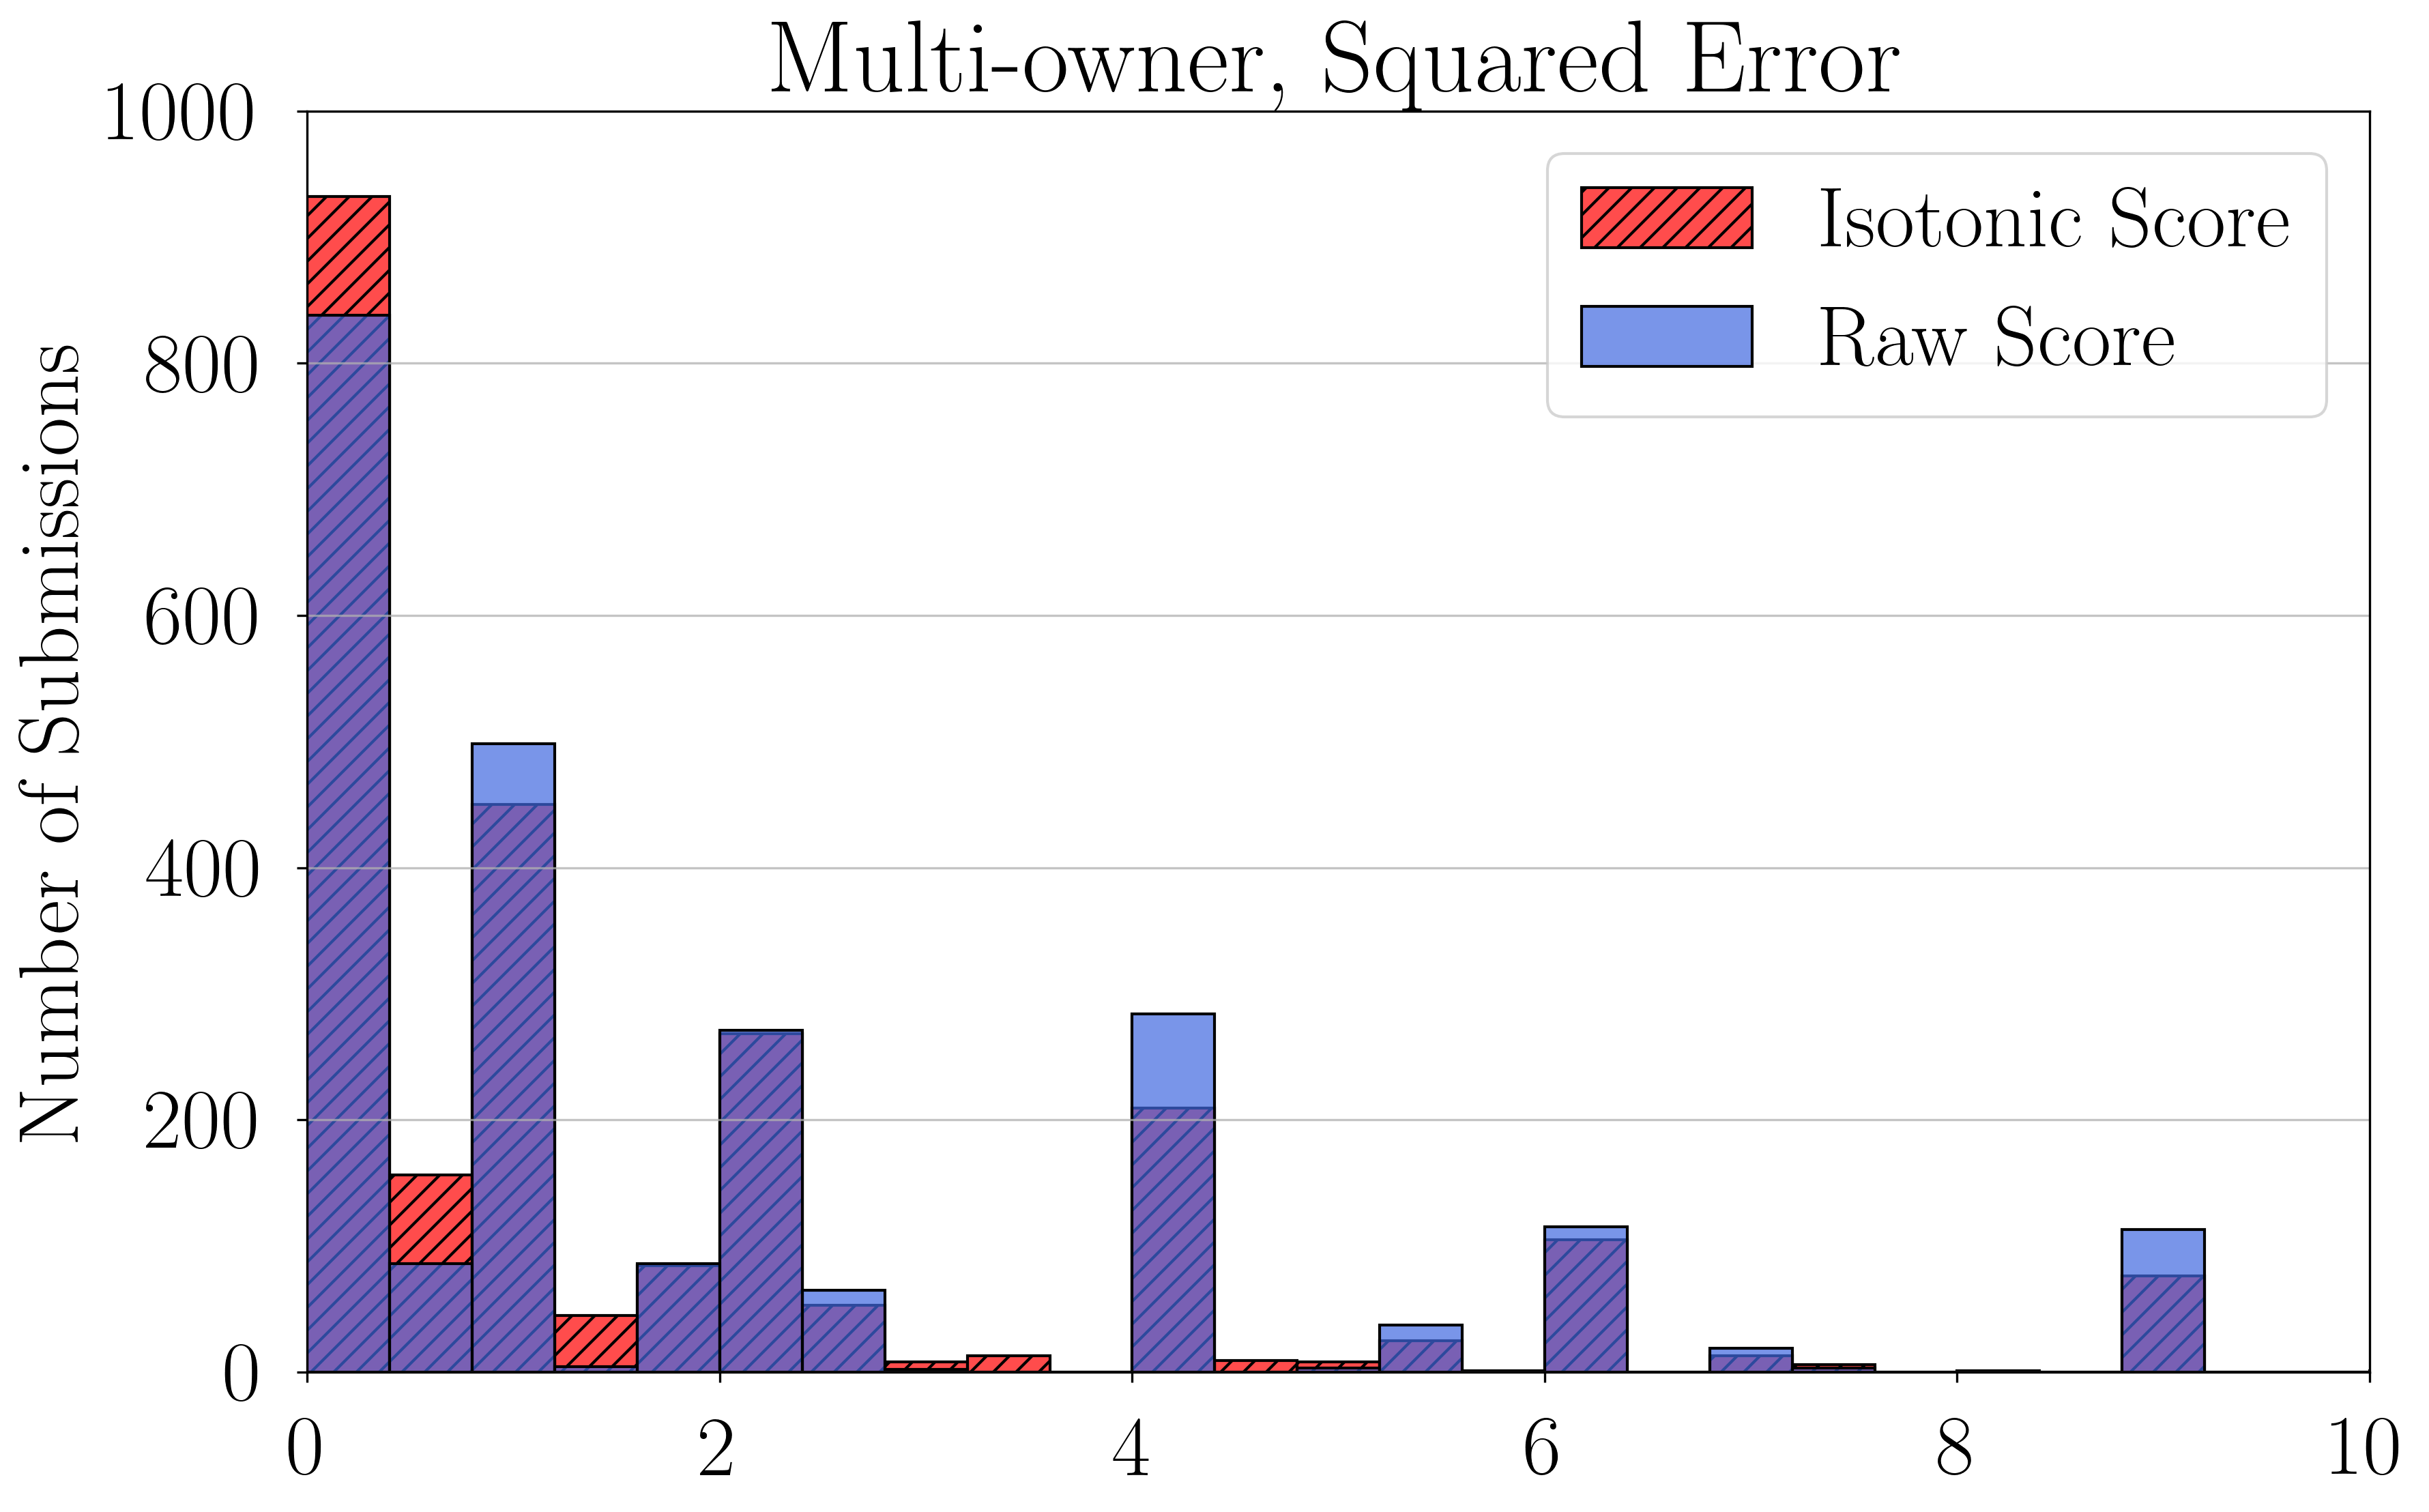

In [27]:
# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='Isotonic Score    ', common_norm=False, alpha=0.7, hatch='///', line_kws={'lw': 2.5} )
# sns.histplot(data=multi_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='After Single Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=False, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Proxy MSE')
plt.ylabel('Number of Submissions')
plt.title('Greedy, Squared Error')
plt.xlim(0, 10)
plt.yticks(range(0, 1001, 200))


plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)


plt.legend()
plt.savefig('/content/drive/MyDrive/Research/ICML_2023_Result/Figures/greedy_iso_proxy_histo_L2.pdf', bbox_inches='tight')
plt.show()

# Create a figure and axis using Seaborn
plt.figure()
#sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='Multi Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )
sns.histplot(data=multi_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='Isotonic Score    ', common_norm=False, alpha=0.7, hatch='///', line_kws={'lw': 2.5} )
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=False, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Proxy MSE')
plt.ylabel('Number of Submissions')
plt.title('Multi-owner, Squared Error')
plt.xlim(0, 10)
plt.yticks(range(0, 1001, 200))


plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)


plt.legend()
plt.savefig('/content/drive/MyDrive/Research/ICML_2023_Result/Figures/multiowner_iso_proxy_histo_L2.pdf', bbox_inches='tight')
plt.show()


## Compute L1 values for all submissions.

In [28]:
# proxy
submission_true_rating = {}
for submission in range(n_2):
    submission_true_rating[submission] = df[df['submission_idx'] == submission]['proxy'].tolist()
    submission_true_rating[submission] = submission_true_rating[submission][0]

True_score_multi_iso = []
for i in range(n_2):
    True_score_multi_iso.append(submission_true_rating[i])



# score
old_rating = {}
for submission in range(n_2):
    old_rating[submission] = df[df['submission_idx'] == submission]['score'].tolist()
    old_rating[submission] = old_rating[submission][0]

old_score_multi_iso = []
for i in range(n_2):
    old_score_multi_iso.append(old_rating[i])



# Create two lists to record: (y - R)^2 and (\hat{R} - R)^2 values.
greedy_diff = []
multi_diff = []
old_diff = []
for i in range(len(True_score_multi_iso)):
  greedy_diff.append( abs(greedy_iso_rating[i] - True_score_multi_iso[i]) )
  multi_diff.append( abs(multi_iso_rating[i] - True_score_multi_iso[i]) )
  old_diff.append( abs(old_score_multi_iso[i] - True_score_multi_iso[i]) )



# print the MSE
print('Greedy Isotonic Mechanism', np.mean(greedy_diff) )
print('Multiowner Isotonic Mechanism', np.mean(multi_diff) )
print('Review Rating', np.mean(old_diff) )



#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_rel(old_diff, greedy_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for greedy:", t_statistic)
print("Before Rebuttal with proxy p-value for greedy:", p_value)



#Perform the paired sample t-test
t_statistic, p_value = stats.ttest_rel(old_diff, multi_diff, alternative='greater')
print("Before Rebuttal with proxy t-test for multi-owner:", t_statistic)
print("Before Rebuttal with proxy p-value for multi-owner:", p_value)

Greedy Isotonic Mechanism 1.1085816478207784
Multiowner Isotonic Mechanism 1.1222717861848297
Review Rating 1.255566534914361
Before Rebuttal with proxy t-test for greedy: 11.960829063957396
Before Rebuttal with proxy p-value for greedy: 2.0584753988190023e-32
Before Rebuttal with proxy t-test for multi-owner: 11.66546899333735
Before Rebuttal with proxy p-value for multi-owner: 5.751012836267072e-31


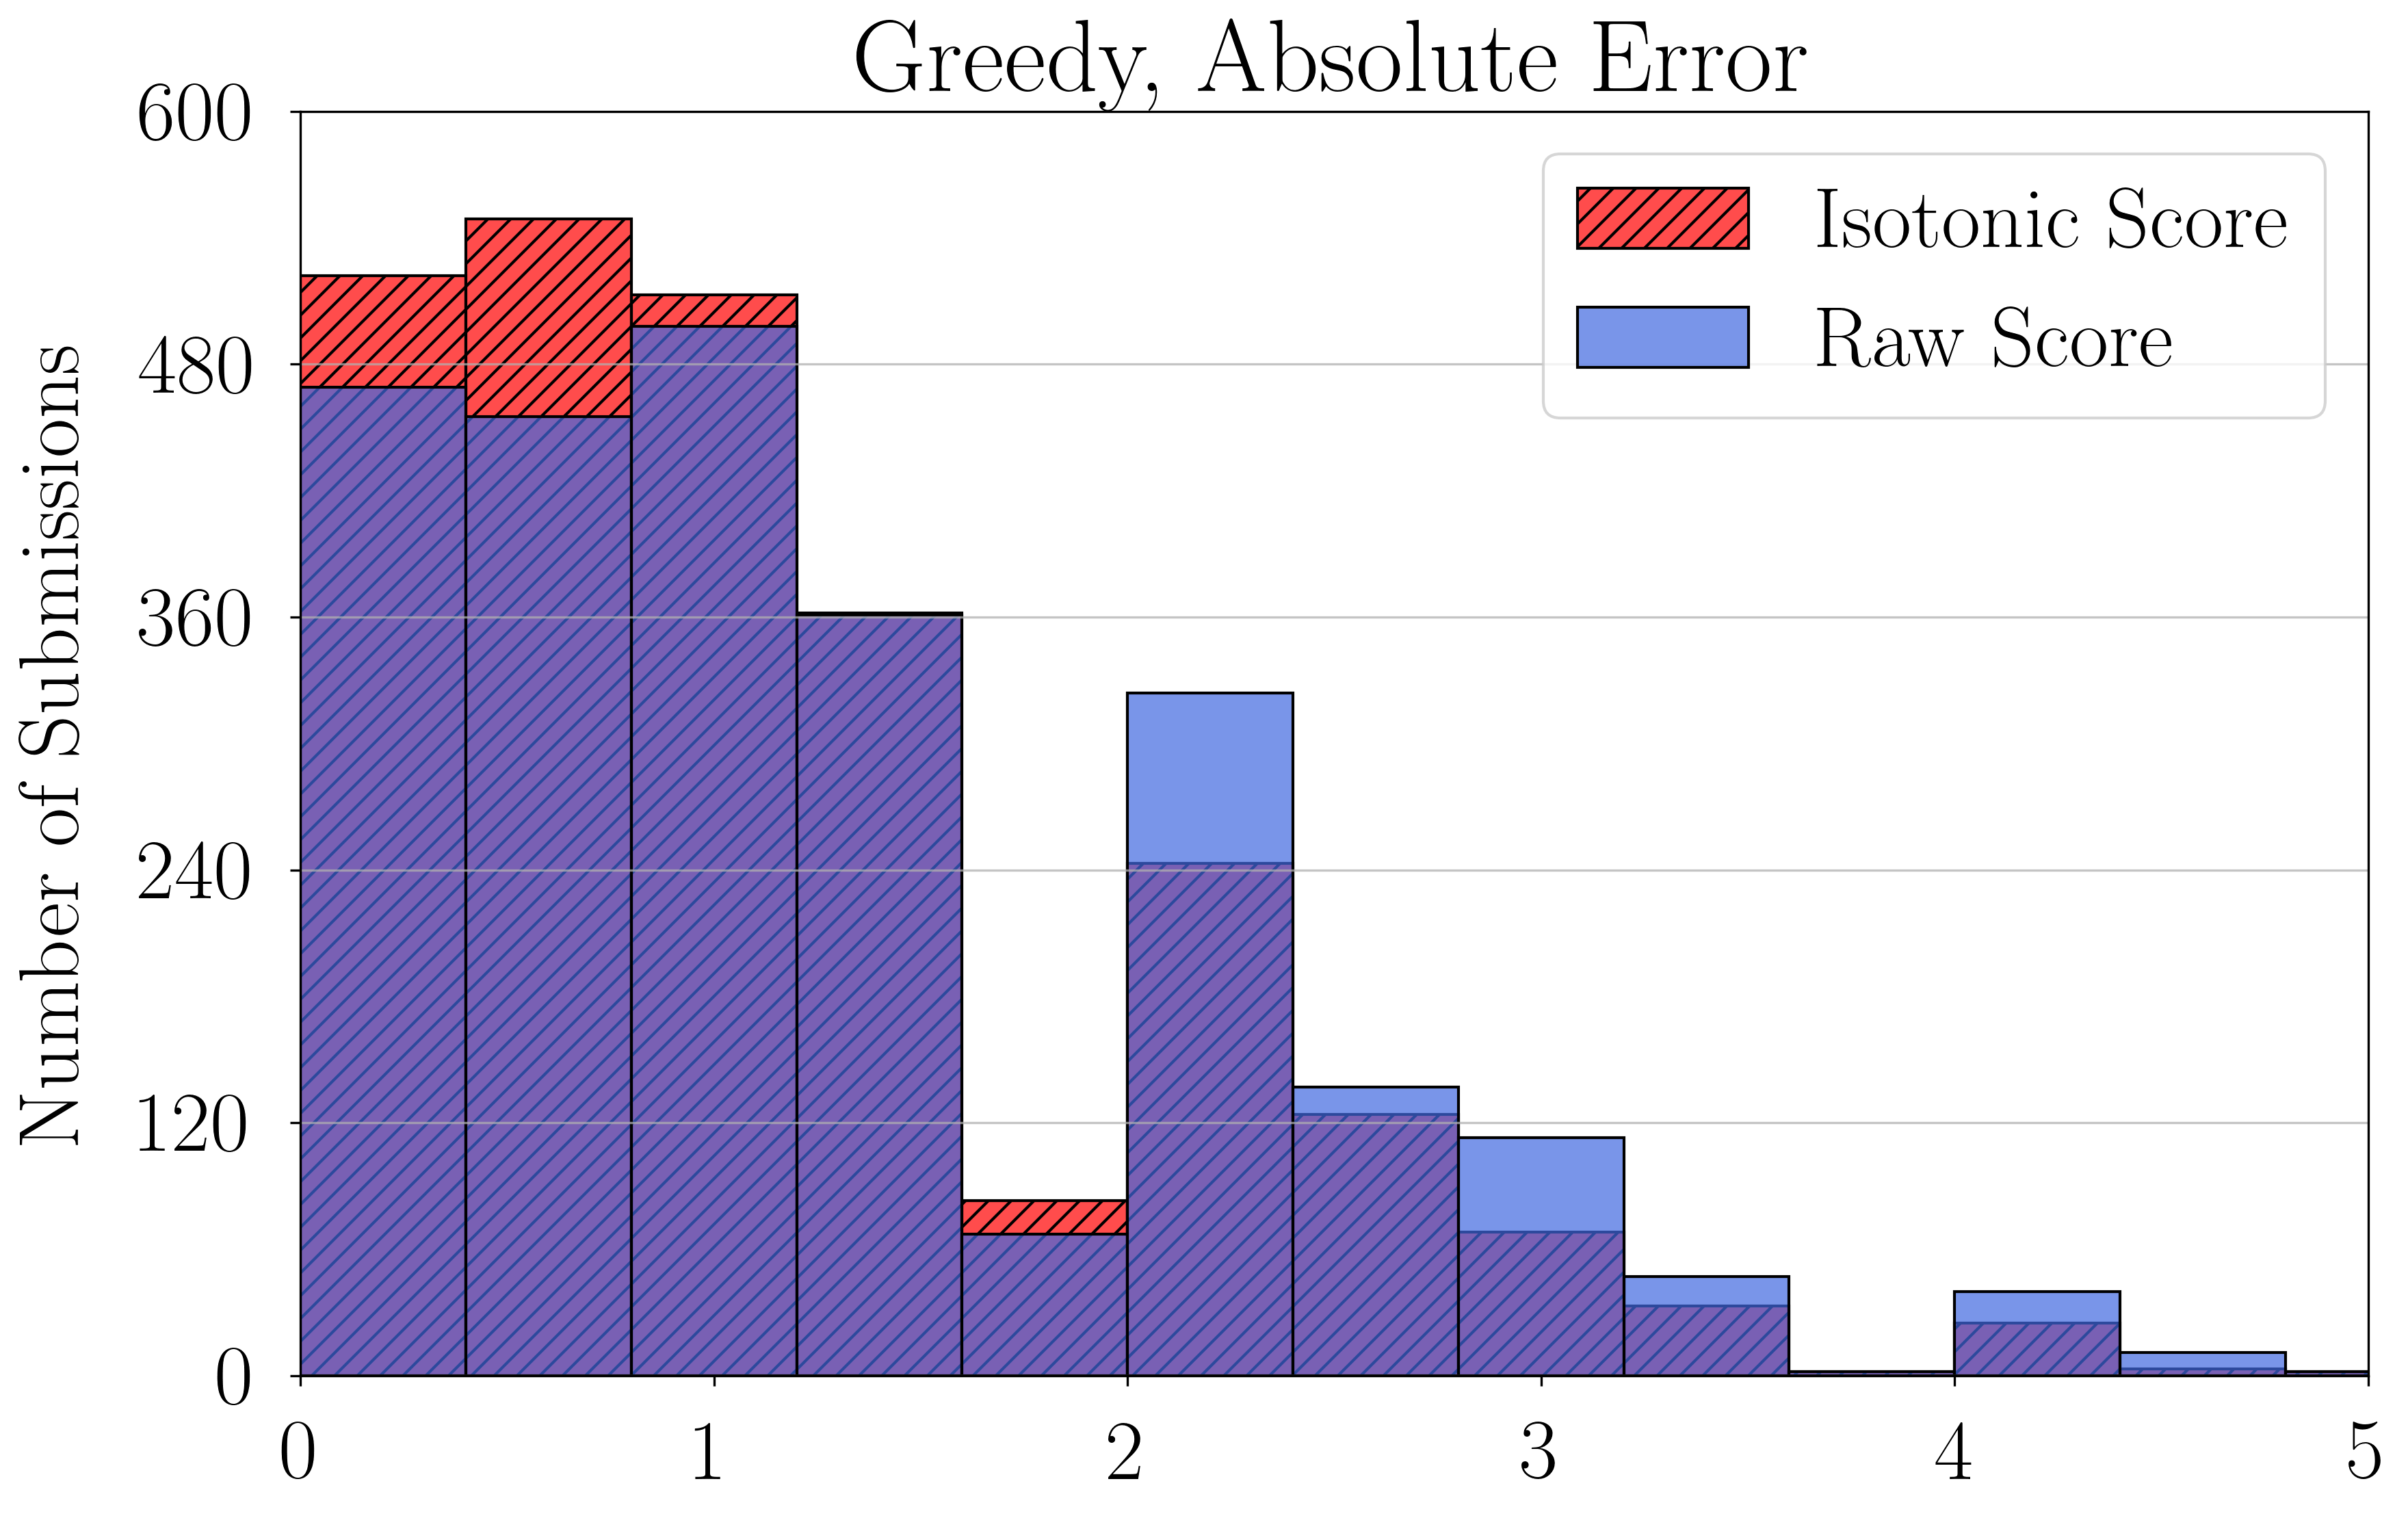

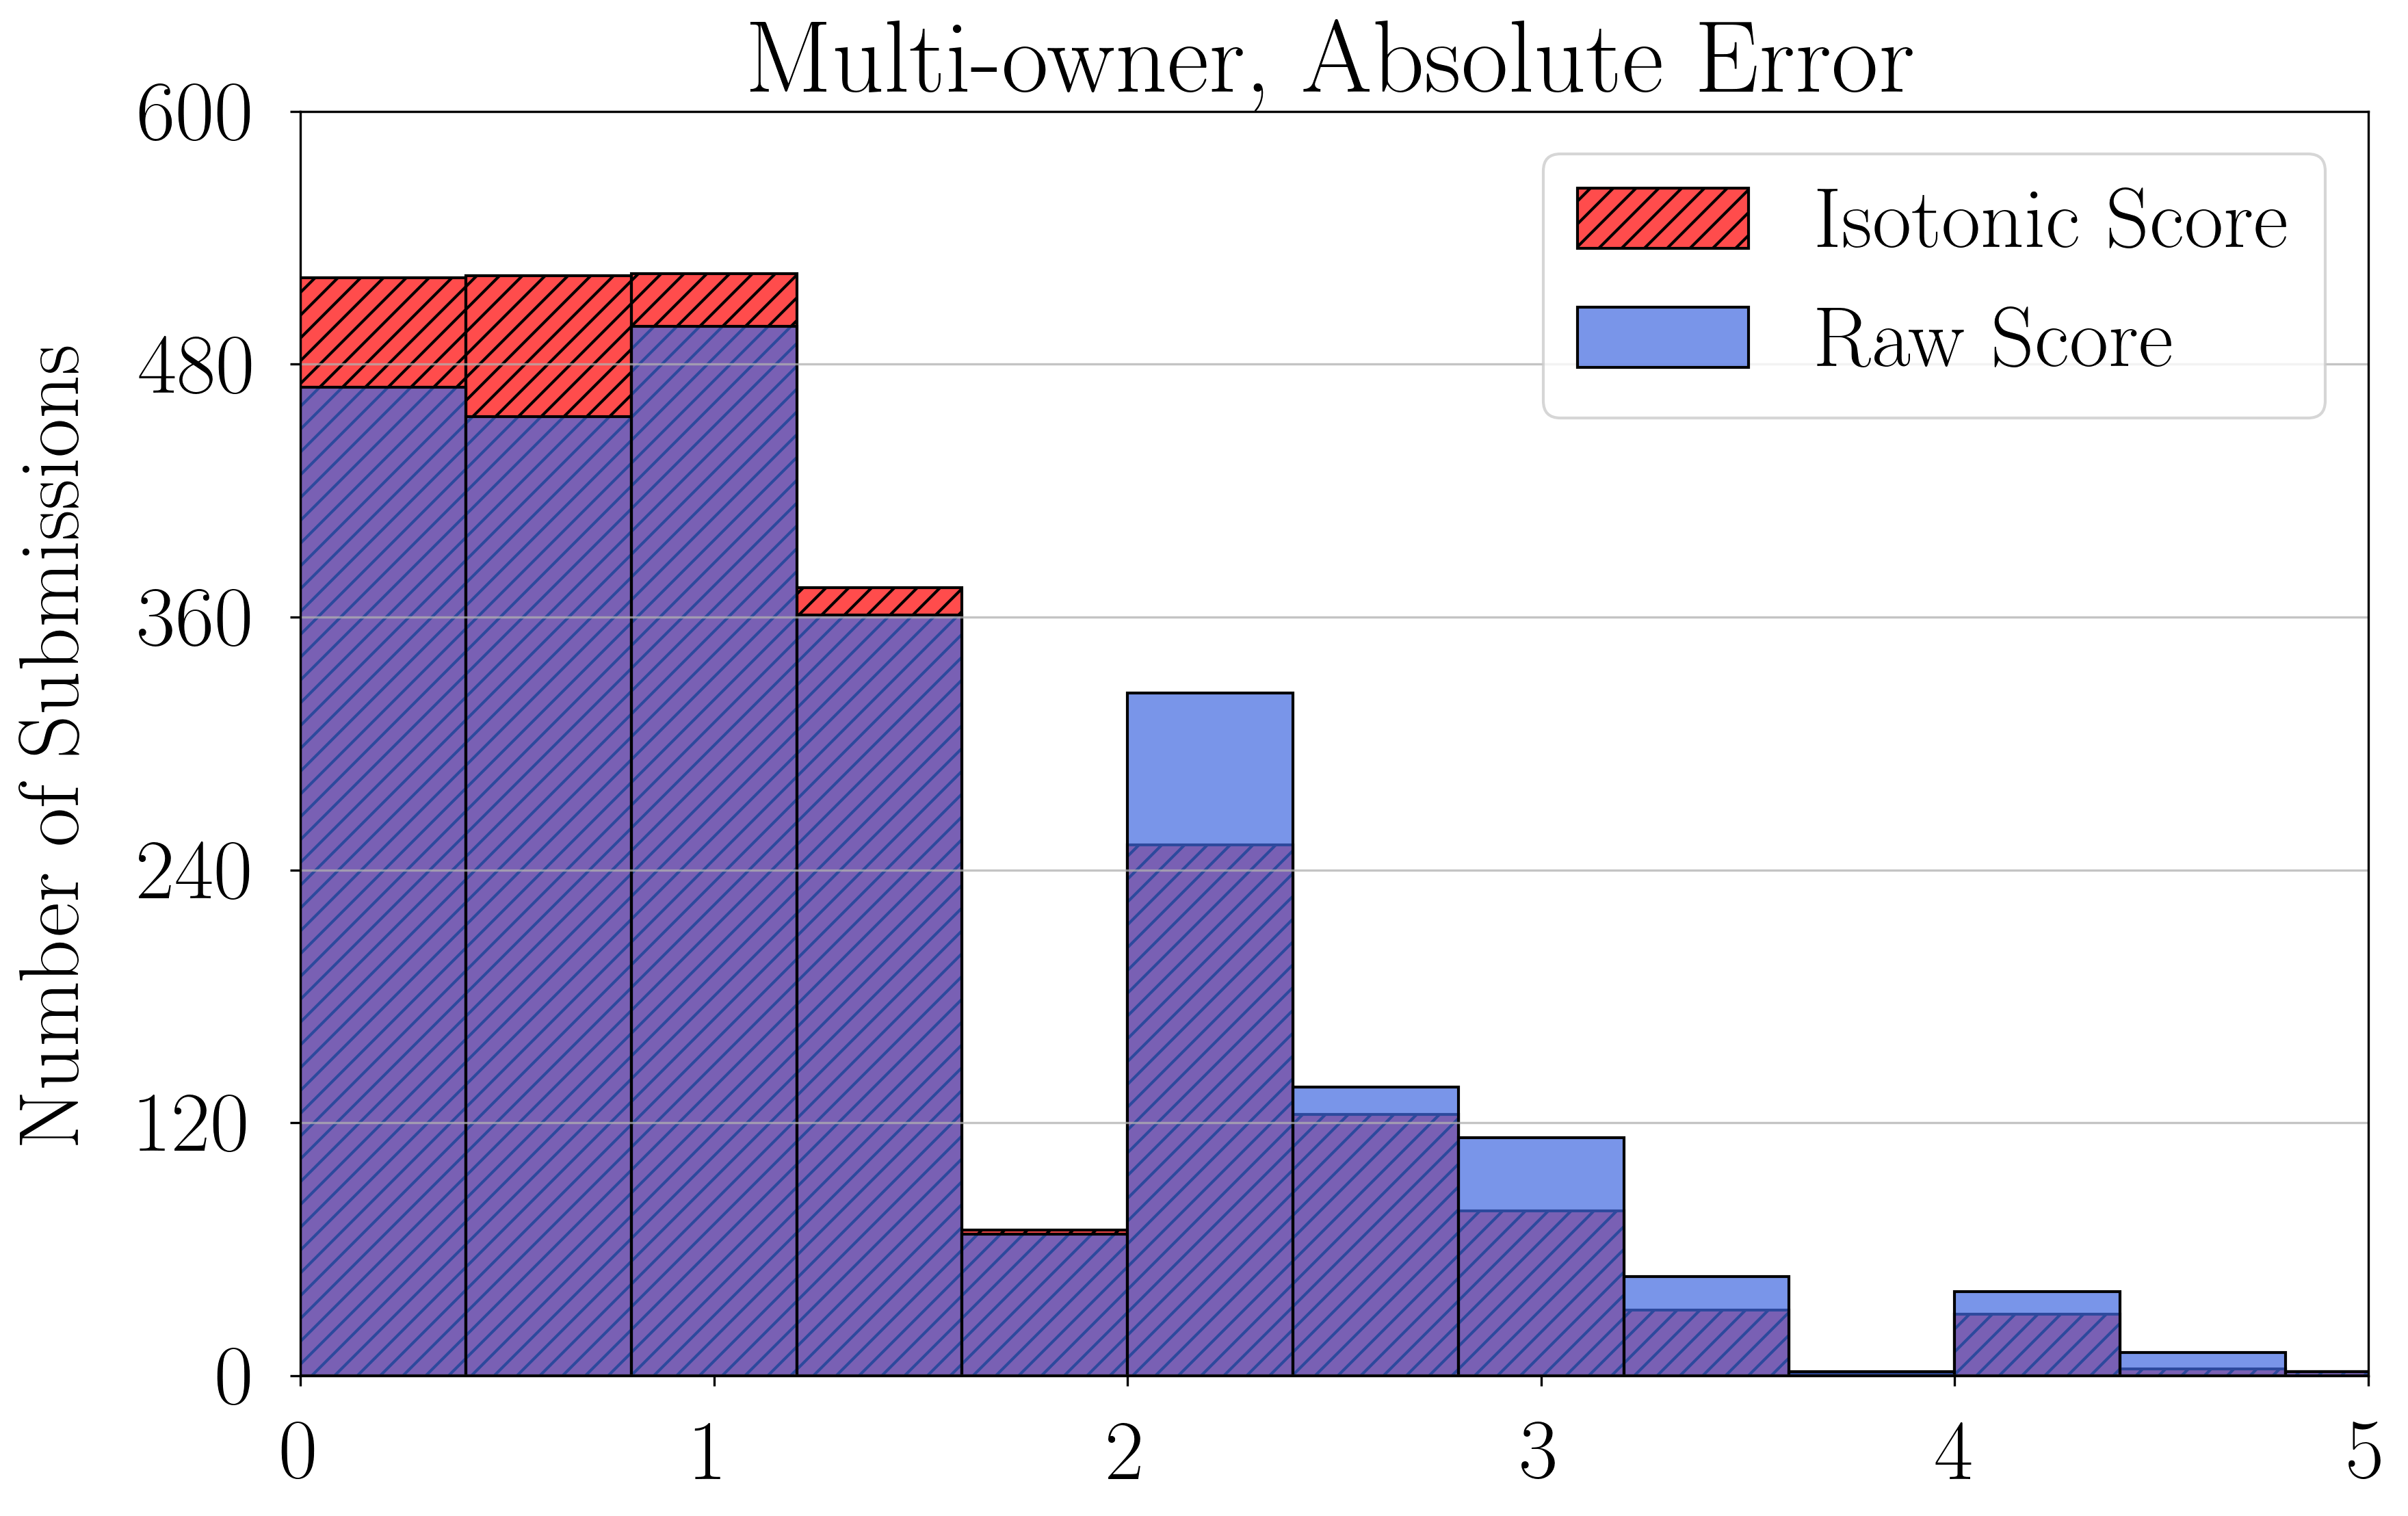

In [29]:
# Create a figure and axis using Seaborn
plt.figure()
sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='Isotonic Score    ', common_norm=False, alpha=0.7, hatch='///', line_kws={'lw': 2.5}, kde_kws={"bw_adjust": 1.5} )
# sns.histplot(data=multi_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='After Single Isotonic   ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5}, kde_kws={"bw_adjust": 1.5} )
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=False, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5}, kde_kws={"bw_adjust": 1.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Proxy MAE')
plt.ylabel('Number of Submissions', labelpad=15)
plt.title('Greedy, Absolute Error')
plt.xlim(0, 5)
plt.yticks(range(0, 601, 120))


plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)


plt.legend()
plt.savefig('/content/drive/MyDrive/Research/ICML_2023_Result/Figures/greedy_iso_proxy_histo_L1.pdf', bbox_inches='tight')
plt.show()

# Create a figure and axis using Seaborn
plt.figure()
#sns.histplot(data=greedy_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='Multi Isotonic   ', common_norm=False, alpha=0.7, hatch='///', line_kws={'lw': 2.5}, kde_kws={"bw_adjust": 1.5} )
sns.histplot(data=multi_diff, bins= np.arange(0, 14, 0.4), color='red', kde=False, label='Isotonic Score    ', common_norm=False, alpha=0.7, hatch='///', line_kws={'lw': 2.5}, kde_kws={"bw_adjust": 1.5} )
sns.histplot(data=old_diff, bins= np.arange(0, 14, 0.4), color='royalblue', kde=False, label='Raw Score    ', common_norm=False, alpha=0.7, line_kws={'lw': 2.5}, kde_kws={"bw_adjust": 1.5} )

# Customize the plot
plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Proxy MAE')
plt.ylabel('Number of Submissions', labelpad=15)
plt.title('Multi-owner, Absolute Error')
plt.xlim(0, 5)
plt.yticks(range(0, 601, 120))


plt.gca().tick_params(axis='x', pad=12)
plt.gca().tick_params(axis='y', pad=12)


plt.legend()
plt.savefig('/content/drive/MyDrive/Research/ICML_2023_Result/Figures/multiowner_iso_proxy_histo_L1.pdf', bbox_inches='tight')
plt.show()
